In [1]:
# Cella 1: Installazione Pulita delle Dipendenze e di ImageBind
import sys

print("=== Inizio installazione pulita delle dipendenze ===")

try:
    # Aggiorna pip per sicurezza
    print("\nAggiornamento di pip...")
    !pip install --upgrade pip

    # Installa ImageBind direttamente dal repository GitHub con tutte le sue dipendenze.
    # Poiché l'ambiente è nuovo con Python 3.9, dovrebbe installare le versioni compatibili di Torch.
    print("\nInstallazione di ImageBind da GitHub (con tutte le dipendenze)...")
    !pip install git+https://github.com/facebookresearch/ImageBind.git

    # Installa le librerie di base per analisi dati e visualizzazione
    print("\nInstallazione di pandas, numpy, matplotlib, tqdm...")
    !pip install pandas numpy matplotlib tqdm

    print("\n✅ Installazione di tutte le dipendenze completata con successo.")

except Exception as e:
    print(f"❌ Errore critico durante l'installazione: {e}")
    sys.exit(1)

print("\n--- Setup completato. Puoi procedere alla Cella 2. ---")

=== Inizio installazione pulita delle dipendenze ===

Aggiornamento di pip...
Installazione di ImageBind da GitHub (con tutte le dipendenze)...

  Cloning https://github.com/facebookresearch/ImageBind.git to c:\users\angel\appdata\local\temp\pip-req-build-sq2n4r_b
  Resolved https://github.com/facebookresearch/ImageBind.git to commit 3fcf5c9039de97f6ff5528ee4a9dce903c5979b3
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached pytorchvideo-0.1.5-py3-none-any.whl

Installazione di pandas, numpy, matplotlib, tqdm...


  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/ImageBind.git 'C:\Users\angel\AppData\Local\Temp\pip-req-build-sq2n4r_b'



✅ Installazione di tutte le dipendenze completata con successo.

--- Setup completato. Puoi procedere alla Cella 2. ---


Utilizzo del dispositivo: cpu

Percorsi dei dati configurati:
{'pairing_csv': 'classifica_abbinamenti_canzoni_immagini.csv', 'image_files_folder': './images100', 'audio_files_folder': './audios100', 'output_statistics_csv': 'imagebind_similarity_statistics.csv', 'output_individual_similarities_csv': 'imagebind_individual_similarities.csv'}
Caricamento del modello ImageBind (pre-addestrato, questo può richiedere diversi minuti e molta RAM/VRAM)...
✅ Modello ImageBind caricato con successo.

Lettura del file CSV di pairing: classifica_abbinamenti_canzoni_immagini.csv
✅ Lette 100 coppie audio-immagine dal CSV.

Inizio elaborazione delle coppie immagine-audio con ImageBind:


Calcolo ImageBind Score:   0%|          | 0/100 [00:00<?, ?it/s]

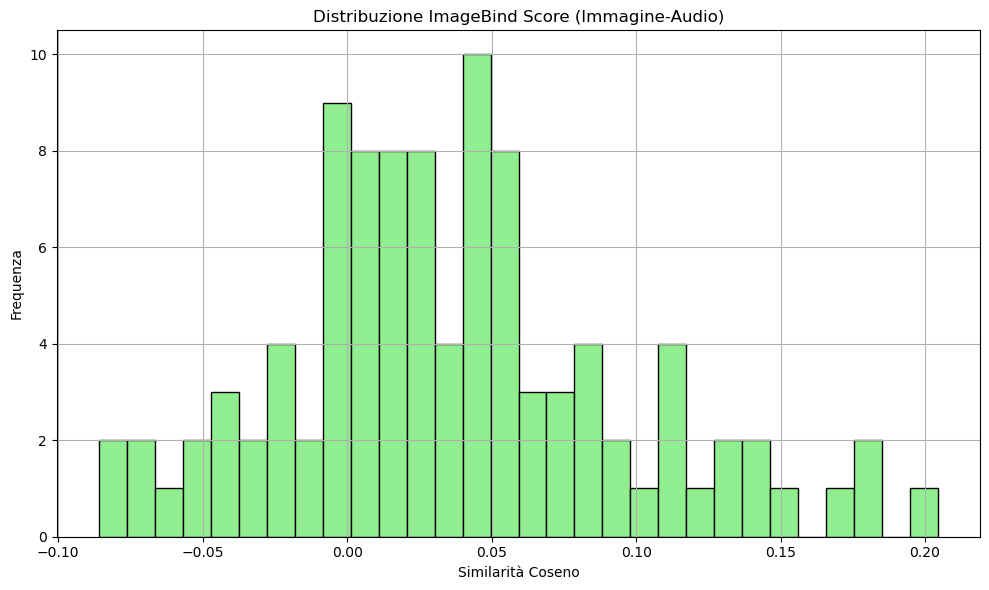


=== Statistiche Complessive ImageBind Score (Immagine-Audio) ===
Numero di coppie elaborate con successo: 100
Media ImageBind Score: 0.0366
Mediana ImageBind Score: 0.0289
Deviazione standard ImageBind Score: 0.0597
Minimo ImageBind Score: -0.0859
Massimo ImageBind Score: 0.2045

✅ Statistiche complessive salvate in 'imagebind_similarity_statistics.csv'
✅ Similarità individuali salvate in 'imagebind_individual_similarities.csv'

=== 🔻 Peggiori match ImageBind Score (Immagine-Audio) ===
Immagine: hiroshige_prune-orchard-sun.jpg, Audio: 025030.mp3, ImageBind Score: -0.0859
Immagine: aleksey-savrasov_courtyard-spring-1853.jpg, Audio: 000714.mp3, ImageBind Score: -0.0798
Immagine: rosalba-carriera_portrait-of-a-young-girl-1708.jpg, Audio: 000615.mp3, ImageBind Score: -0.0702
Immagine: tamara-de-lempicka_portrait-of-kizette-adult-i-1955.jpg, Audio: 000897.mp3, ImageBind Score: -0.0678
Immagine: john-flaxman_illustration-to-the-iliad-1795-25.jpg, Audio: 000709.mp3, ImageBind Score: -0.0659


In [4]:
# Cella 2: Script Principale per il Calcolo dell'ImageBind Score

# --- Import delle librerie necessarie (incluse quelle di ImageBind) ---
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import traceback
import csv
import os
from imagebind.models import imagebind_model
from imagebind.models.imagebind_model import ModalityType
from imagebind import data


# --- 1. Configurazione Iniziale ---
# Se hai una GPU, ImageBind la userà automaticamente.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Utilizzo del dispositivo: {device}")

# --- PERCORSI DEI TUOI FILE LOCALI ---
# *** DEVI AGGIORNARE QUESTI PERCORSI CON QUELLI REALI SUL TUO PC! ***
PATHS = {
    "pairing_csv": "classifica_abbinamenti_canzoni_immagini.csv",
    "image_files_folder": "./images100",
    "audio_files_folder": "./audios100",
    "output_statistics_csv": "imagebind_similarity_statistics.csv",
    "output_individual_similarities_csv": "imagebind_individual_similarities.csv",
}
print(f"\nPercorsi dei dati configurati:\n{PATHS}")

# --- 2. Caricamento Modello ImageBind ---
try:
    print("Caricamento del modello ImageBind (pre-addestrato, questo può richiedere diversi minuti e molta RAM/VRAM)...")

    imagebind_model_instance = imagebind_model.imagebind_huge(pretrained=True)

    imagebind_model_instance.eval()
    imagebind_model_instance.to(device)
    print("✅ Modello ImageBind caricato con successo.")
except Exception as e:
    print(f"❌ Errore durante il caricamento del modello ImageBind: {e}")
    traceback.print_exc(file=sys.stdout)
    sys.exit(1)

# --- 3. Funzioni di Supporto ---
def load_and_preprocess_image(image_path):
    """Carica e preprocessa un'immagine per ImageBind."""
    try:
        return data.load_and_transform_vision_data([image_path], device)
    except Exception as e:
        print(f"Errore durante il pre-processing dell'immagine {os.path.basename(image_path)}: {e}")
        return None

def load_and_preprocess_audio(audio_path):
    """Carica e preprocessa un audio per ImageBind."""
    try:
        return data.load_and_transform_audio_data([audio_path], device)
    except Exception as e:
        print(f"Errore durante il pre-processing dell'audio {os.path.basename(audio_path)}: {e}")
        return None

def calculate_cosine_similarity(embedding1, embedding2):
    """Calcola la similarità coseno tra due vettori embedding."""
    if embedding1 is None or embedding2 is None:
        return np.nan

    embedding1_norm = torch.nn.functional.normalize(embedding1, p=2, dim=-1)
    embedding2_norm = torch.nn.functional.normalize(embedding2, p=2, dim=-1)

    return (embedding1_norm * embedding2_norm).sum(dim=-1).item()


# --- 4. Lettura del CSV di Pairing ---
print(f"\nLettura del file CSV di pairing: {PATHS['pairing_csv']}")
paired_data = []

try:
    with open(PATHS['pairing_csv'], 'r', encoding='utf-8') as f:
        reader = csv.reader(f)
        header = next(reader)

        try:
            audio_col_idx = header.index('Canzone')
            image_col_idx = header.index('Immagine Abbinata')
        except ValueError:
            print("❌ Errore: Le colonne 'Canzone' o 'Immagine Abbinata' non trovate nel CSV. Assicurati che i nomi delle colonne nel CSV corrispondano esattamente a 'Canzone' e 'Immagine Abbinata'.")
            sys.exit(1)

        for i, row in enumerate(reader):
            if len(row) > max(audio_col_idx, image_col_idx):
                audio_filename = row[audio_col_idx].strip()
                image_filename = row[image_col_idx].strip()
                if audio_filename and image_filename:
                    paired_data.append({
                        'audio_filename': audio_filename,
                        'audio_path': os.path.join(PATHS['audio_files_folder'], audio_filename), # Aggiunto path completo per comodità
                        'image_filename': image_filename,
                        'image_path': os.path.join(PATHS['image_files_folder'], image_filename) # Aggiunto path completo per comodità
                    })

    print(f"✅ Lette {len(paired_data)} coppie audio-immagine dal CSV.")

except FileNotFoundError:
    print(f"❌ Errore: Il file CSV '{PATHS['pairing_csv']}' non trovato. Controlla il percorso nel dizionario PATHS.")
    sys.exit(1)
except Exception as e:
    print(f"❌ Errore durante la lettura del CSV: {e}")
    traceback.print_exc(file=sys.stdout)
    sys.exit(1)

if not paired_data:
    print("❌ Nessuna coppia audio-immagine valida trovata nel CSV. Impossibile procedere.")
    sys.exit(1)

# --- 5. Elaborazione delle Coppie e Calcolo ImageBind Score ---
all_similarities = []
individual_results = []
skipped_pairs_count = 0

print("\nInizio elaborazione delle coppie immagine-audio con ImageBind:")
for item in tqdm(paired_data, desc="Calcolo ImageBind Score"):
    audio_file = item['audio_filename']
    image_file = item['image_filename']

    full_image_path = item['image_path'] # Usiamo il path pre-calcolato
    full_audio_path = item['audio_path'] # Usiamo il path pre-calcolato

    if not os.path.exists(full_image_path):
        print(f"⚠️ Skipped: Immagine non trovata: {full_image_path}")
        skipped_pairs_count += 1
        continue
    if not os.path.exists(full_audio_path):
        print(f"⚠️ Skipped: Audio non trovato: {full_audio_path}")
        skipped_pairs_count += 1
        continue

    try:
        image_data = load_and_preprocess_image(full_image_path)
        audio_data = load_and_preprocess_audio(full_audio_path)

        if image_data is None or audio_data is None:
            skipped_pairs_count += 1
            continue

        inputs = {
            ModalityType.VISION: image_data,
            ModalityType.AUDIO: audio_data,
        }

        with torch.no_grad():
            embeddings = imagebind_model_instance(inputs)

        image_emb = embeddings[ModalityType.VISION]
        audio_emb = embeddings[ModalityType.AUDIO]

        similarity = calculate_cosine_similarity(image_emb, audio_emb)

        all_similarities.append(similarity)
        individual_results.append({
            'Image Filename': image_file,
            'Audio Filename': audio_file,
            'ImageBind Score': similarity
        })

    except Exception as e:
        print(f"❌ Errore critico durante l'elaborazione della coppia {image_file} - {audio_file}: {e}")
        traceback.print_exc(file=sys.stdout)
        skipped_pairs_count += 1
        continue

if not all_similarities:
    print("\n❌ Nessuna coppia è stata elaborata con successo per calcolare l'ImageBind Score. Controlla i percorsi dei file e i log degli errori.")
    if skipped_pairs_count > 0:
        print(f"Numero di coppie saltate a causa di file mancanti o errori di elaborazione: {skipped_pairs_count}")
    sys.exit(1)

all_similarities_np = np.array(all_similarities)

# --- 6. Visualizzazione Distribuzione Similarità ---
plt.figure(figsize=(10, 6))
plt.hist(all_similarities_np, bins=30, color='lightgreen', edgecolor='black')
plt.title("Distribuzione ImageBind Score (Immagine-Audio)")
plt.xlabel("Similarità Coseno")
plt.ylabel("Frequenza")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 7. Statistiche Complessive ---
print("\n=== Statistiche Complessive ImageBind Score (Immagine-Audio) ===")
num_pairs_processed = len(all_similarities_np)
mean_sim = np.mean(all_similarities_np)
median_sim = np.median(all_similarities_np)
std_sim = np.std(all_similarities_np)
min_sim = np.min(all_similarities_np)
max_sim = np.max(all_similarities_np)

print(f"Numero di coppie elaborate con successo: {num_pairs_processed}")
if skipped_pairs_count > 0:
    print(f"Numero totale di coppie saltate (file non trovati o errori): {skipped_pairs_count}")
print(f"Media ImageBind Score: {mean_sim:.4f}")
print(f"Mediana ImageBind Score: {median_sim:.4f}")
print(f"Deviazione standard ImageBind Score: {std_sim:.4f}")
print(f"Minimo ImageBind Score: {min_sim:.4f}")
print(f"Massimo ImageBind Score: {max_sim:.4f}")

# --- 8. Salvataggio Statistiche Complessive su CSV ---
try:
    stats_df = pd.DataFrame({
        'Metrica': ['Numero di Coppie Elaborate', 'Coppie Saltate', 'Media ImageBind Score', 'Mediana ImageBind Score', 'Deviazione Standard ImageBind Score', 'Minimo ImageBind Score', 'Massimo ImageBind Score'],
        'Valore': [num_pairs_processed, skipped_pairs_count, mean_sim, median_sim, std_sim, min_sim, max_sim]
    })
    stats_df.to_csv(PATHS["output_statistics_csv"], index=False)
    print(f"\n✅ Statistiche complessive salvate in '{PATHS['output_statistics_csv']}'")
except Exception as e:
    print(f"❌ Errore durante il salvataggio delle statistiche: {e}")
    traceback.print_exc(file=sys.stdout)

# --- 9. Salvataggio Similarità Individuali ---
if individual_results:
    try:
        individual_sim_df = pd.DataFrame(individual_results)
        individual_sim_df.to_csv(PATHS["output_individual_similarities_csv"], index=False)
        print(f"✅ Similarità individuali salvate in '{PATHS['output_individual_similarities_csv']}'")
    except Exception as e:
        print(f"❌ Errore durante il salvataggio delle similarità individuali: {e}")
        traceback.print_exc(file=sys.stdout)
else:
    print("\n⚠️ Nessuna similarità individuale da salvare.")

# --- 10. Visualizza Esempi Migliori e Peggiori ---
if individual_results:
    results_df = pd.DataFrame(individual_results)
    results_df = results_df.sort_values(by='ImageBind Score', ascending=True).reset_index(drop=True)

    def print_examples(df_sorted, title, num_examples=5):
        print(f"\n=== {title} ===")
        for i in range(min(num_examples, len(df_sorted))):
            row = df_sorted.iloc[i]
            print(f"Immagine: {row['Image Filename']}, Audio: {row['Audio Filename']}, ImageBind Score: {row['ImageBind Score']:.4f}")

    print_examples(results_df.head(5), "🔻 Peggiori match ImageBind Score (Immagine-Audio)")
    print_examples(results_df.tail(5).sort_values(by='ImageBind Score', ascending=False), "🔺 Migliori match ImageBind Score (Immagine-Audio)")
else:
    print("\n⚠️ Nessun risultato da visualizzare per gli esempi migliori/peggiori.")

print("\nProcesso di calcolo ImageBind Score completato.")